In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv("train_v3.csv", index_col="Datetime")

In [5]:
df.columns

Index(['Category_3', 'Category_1', 'Price', 'Number_Of_Sales', 'DayOfMonth',
       'DayCount', 'cat_2_1.0', 'cat_2_2.0', 'cat_2_3.0', 'cat_2_4.0',
       'cat_2_5.0', 'cat_2_other', 'week_0', 'week_1', 'week_2', 'week_3',
       'week_4', 'week_5', 'week_6', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'is_weekend', 'quarter_1',
       'quarter_2', 'quarter_3', 'quarter_4'],
      dtype='object')

In [6]:
df = df[df["Number_Of_Sales"] < 1255]
# df = df[df["Price"] < 5.0]

In [7]:
X = df.drop(['Price', 'Number_Of_Sales'], axis=1)

In [8]:
X.columns

Index(['Category_3', 'Category_1', 'DayOfMonth', 'DayCount', 'cat_2_1.0',
       'cat_2_2.0', 'cat_2_3.0', 'cat_2_4.0', 'cat_2_5.0', 'cat_2_other',
       'week_0', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'is_weekend', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4'],
      dtype='object')

In [9]:
scaler = StandardScaler()
scaler.fit(df["Category_1"])
df["Category_1"] = scaler.transform(df["Category_1"])

/home/iamnewneo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/iamnewneo/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [10]:
y_sales = df["Number_Of_Sales"]
y_price = df["Price"]

In [11]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error as mse

/home/iamnewneo/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
def rmse(act_y, pred_y):
    return np.sqrt(mse(act_y, pred_y))

In [13]:
import xgboost as xgb

# Hyperopt

In [14]:
SEED = 314159265
VALID_SIZE = 0.2
TARGET = 'outcome'

In [15]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [16]:
def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test)
#     dvalid = xgb.DMatrix(X_test, label=y_test)
#     watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    model = xgb.train(params, dtrain, num_round)
    
    predictions = model.predict(dvalid)
    score = rmse(y_test, predictions)
    # TODO: Add the importance for the selected features
    print("Score {0}\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

def optimize(trials):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 400, 1000, 50),
             'eta' : hp.quniform('eta', 0.05, 0.3, 0.05),
             'max_depth' : hp.choice('max_depth', np.arange(3, 14, dtype=int)),
             'min_child_weight' : hp.quniform('min_child_weight', 2, 6, 1),
             'subsample' : hp.quniform('subsample', 0.6, 1, 0.05),
             'gamma' : hp.quniform('gamma', 0.5, 0.8, 0.1),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.6, 1, 0.1),
             'eval_metric': 'rmse',
             'objective': 'reg:linear',
             'silent' : 1
             }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=20)
    print("\n\n")
    print("Best Model is: ")
    print(best)
    return best

## Sales_Prediction

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y_sales)

In [18]:
def runXGB(train_X, train_y, test_X, test_y=None):
#     params = {}
#     params["objective"] = "reg:linear"
#     params["eta"] = 0.02
#     params["min_child_weight"] = 8
#     params["subsample"] = 0.9
#     params["colsample_bytree"] = 0.8
#     params["silent"] = 1
#     params["max_depth"] = 8
#     params["seed"] = 1
# plst = list(params.items())
# num_rounds = 1000
    params = {
            'subsample': 0.9,
            'eta': 0.2,
            'objective': 'reg:linear',
            'n_estimators': 500.0,
            'min_child_weight': 3.0,
            'silent': 1,
            'max_depth': 8,
            'colsample_bytree': 0.8,
            'gamma': 0.8,
            'eval_metric': 'rmse'
        }
    num_rounds = int(params['n_estimators'])
    del params['n_estimators']
    
    
    xgtrain = xgb.DMatrix(train_X, label=train_y)
#     xgtest = xgb.DMatrix(test_X)
    model = xgb.train(params, xgtrain, num_rounds)
#     model = xgb.train(plst, xgtrain, num_rounds)
#     pred_test_y = model.predict(xgtest)
    return model

In [19]:
sales_model = runXGB(X_train, y_train, X_test)

In [20]:
y_sales_pred = sales_model.predict(xgb.DMatrix(X_test))
score = rmse(y_test, y_sales_pred)
print(score)

143.005483549


In [21]:
sales_model.save_model("sales_model_train_v4.model")
sales_model.dump_model('raw_sales_model_train_v4.txt')

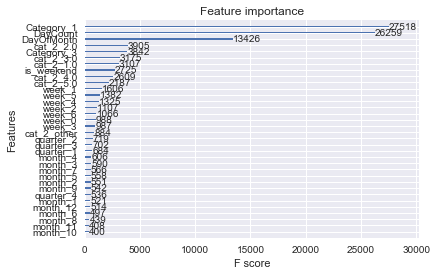

In [23]:
from xgboost import plot_importance
plot_importance(sales_model)

In [ ]:
# trials = Trials()

# best_model = optimize(trials)

In [ ]:
# np.save('best_parameters_sales.npy', best_model)

In [ ]:
#best params
# {'gamma': 0.55, 'colsample_bytree': 0.65, 'silent': 1, 'max_depth': 7, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'n_estimators': 730.0, 'subsample': 0.8, 'eta': 0.225, 'min_child_weight': 3.0}